In [26]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier, Dataset
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
from get_metrics1 import get_metrics_classification
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from SupFunctions import check_overfitting_classification, scale_pos_weight_calc
import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=RuntimeWarning)

RAND = 10
N_FOLD = 5


In [27]:
df_credit = pd.read_csv('df_credit.csv')

In [28]:
df_credit.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [29]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44961 entries, 0 to 44960
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      44961 non-null  float64
 1   person_gender                   44961 non-null  object 
 2   person_education                44961 non-null  object 
 3   person_income                   44961 non-null  float64
 4   person_emp_exp                  44961 non-null  int64  
 5   person_home_ownership           44961 non-null  object 
 6   loan_amnt                       44961 non-null  float64
 7   loan_intent                     44961 non-null  object 
 8   loan_int_rate                   44961 non-null  float64
 9   loan_percent_income             44961 non-null  float64
 10  cb_person_cred_hist_length      44961 non-null  float64
 11  credit_score                    44961 non-null  int64  
 12  previous_loan_defaults_on_file  

# Split data

Как было отмечено в EDA анализе, присутствует дизбаланс классов.

In [30]:
X = df_credit.drop(['loan_status'], axis=1)
y = df_credit['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y, 
                                                    random_state=RAND)

In [31]:
meta_X = pd.DataFrame(index=X_train.index)  # Создаем DataFrame с теми же индексами, что и X_train
meta_X_test = pd.DataFrame(index=X_test.index)

## CatBoost Classifier Baseline

1. Обучим baseline Catboost на HoldOut:

In [32]:
cat_features = list(df_credit.select_dtypes(include=['object']).columns)

In [33]:
skf = StratifiedKFold(n_splits=N_FOLD, random_state=RAND, shuffle=True)
score_oof = []
finish_test_preds = []
finish_test_preds_proba = []
for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

    cb = CatBoostClassifier(scale_pos_weight=scale_pos_weight_calc(y),
                               cat_features = cat_features,
                               random_state=RAND, 
                               verbose=0) 
    model = CalibratedClassifierCV(estimator=cb, method='isotonic', cv=3) 

    model.fit(X_train_, y_train_, eval_set=(X_val, y_val), early_stopping_rounds=10)

    # oof
    preds_val = model.predict(X_val)
    score_oof.append(f1_score(y_val, preds_val))

    print("Fold:", fold + 1, "F1-SCORE Validation %.3f" % f1_score(y_val, preds_val))
    print("---")

    # holdout
    preds_test = model.predict(X_test)
    preds_test_proba = model.predict_proba(X_test)[:, 1]

    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)

    meta_X.loc[X_val.index, 'catboost_baseline'] = model.predict_proba(X_val)[:, 1]  

print('F1-SCORE mean oof: %.3f, std: %.3f' % (np.mean(score_oof), np.std(score_oof)))

meta_X_test['catboost_baseline'] = np.mean(finish_test_preds_proba, axis=0) 

Fold: 1 F1-SCORE Validation 0.830
---
Fold: 2 F1-SCORE Validation 0.829
---
Fold: 3 F1-SCORE Validation 0.830
---
Fold: 4 F1-SCORE Validation 0.823
---
Fold: 5 F1-SCORE Validation 0.833
---
F1-SCORE mean oof: 0.829, std: 0.003


In [34]:
# Находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]

# Находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

# Вычисляем F1-макро для валидации (OOF)
print('F1-macro mean OOF: %.3f, std: %.3f' %
      (np.mean(score_oof), np.std(score_oof)))

# Вычисляем F1-макро для тестового набора
f1_test = f1_score(y_test, test_pred, average='macro')
print('F1-macro HOLDOUT: %.3f' % f1_test)

F1-macro mean OOF: 0.829, std: 0.003
F1-macro HOLDOUT: 0.895


In [35]:
df_metrics = get_metrics_classification(y_test, 
                                        test_pred, 
                                        test_pred_proba,
                                        "Catboost baseline Holdout")
df_metrics

,model,Accuracy,ROC_AUC,Logloss,Precision,Recall,f1
0,Catboost baseline Holdout,0.93039,0.977312,0.153096,0.889835,0.783892,0.833511


In [36]:
check_overfitting_classification(model,
                  X_train,
                  y_train,
                  X_test,
                  y_test)

ROC-AUC train: 0.980
ROC-AUC test: 0.976
delta = 0.3 %


(0.9795958392287807, 0.9763785953600191, 0.32950782453145155)

In [37]:
y_pred_final = model.predict(X_test)

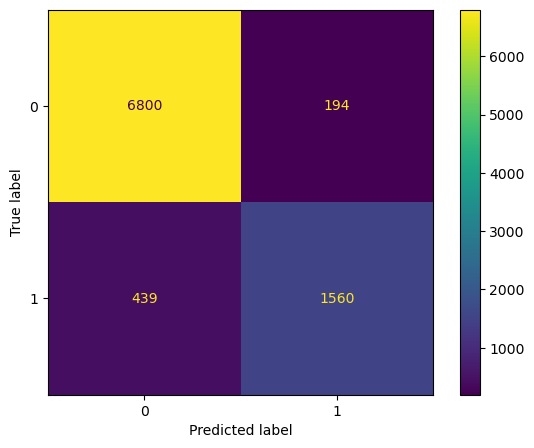

In [38]:
def plot_confusion_matrix(y_true, y_pred, ax=None):
    """Визуализация ConfusionMatrix"""
    labels = list(set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)
    else:
        disp.plot()

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(7, 5))

# Визуализируем матрицу ошибок
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_final, ax=ax)
plt.show()

## LGBM Classifier Baseline

Для того чтобы учесть дизбаланс классов в модели LightGBM, нужно бинаризовать категориальные данные

In [39]:
# Применяем get_dummies к обучающим данным
X_train_encoded = pd.get_dummies(X_train, columns=cat_features, drop_first=True)

# Для тестовых данных используем те же dummy-колонки
X_test_encoded = pd.get_dummies(X_test, columns=cat_features, drop_first=True)

# Выравниваем колонки в тестовых данных по обучающим
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0
X_test_encoded = X_test_encoded[X_train_encoded.columns]

In [40]:
# Для кросс-валидации
skf = StratifiedKFold(n_splits=N_FOLD, random_state=RAND, shuffle=True)
score_oof = []
finish_test_preds = []
finish_test_preds_proba = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_encoded, y_train)):
    # Разделение на train/val внутри обучающей выборки
    X_train_, X_val = X_train_encoded.iloc[train_index], X_train_encoded.iloc[val_index]
    y_train_, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Создаем и обучаем модель
    lgbm = LGBMClassifier(objective='binary',
                          class_weight='balanced',
                          random_state=RAND,
                          verbose=0)    
    model = CalibratedClassifierCV(estimator=lgbm, method='isotonic', cv=3)

    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], eval_metric='logloss')
    
    # Предсказания на валидации
    preds_val = model.predict(X_val)
    score_oof.append(f1_score(y_val, preds_val))
    
    print(f"Fold: {fold + 1} F1-SCORE Validation {f1_score(y_val, preds_val):.3f}")
    print("---")
    
    # Предсказания на тесте
    preds_test = model.predict(X_test_encoded)
    preds_test_proba = model.predict_proba(X_test_encoded)[:, 1]
    
    finish_test_preds.append(preds_test)
    finish_test_preds_proba.append(preds_test_proba)
    
    meta_X.loc[X_val.index, 'lgbm_baseline'] = model.predict_proba(X_val)[:, 1]

print(f'F1-SCORE mean oof: {np.mean(score_oof):.3f}, std: {np.std(score_oof):.3f}')
meta_X_test['lgbm_baseline'] = np.mean(finish_test_preds_proba, axis=0) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fold: 1 F1-SCORE Validation 0.834
---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Fo

In [41]:
# Находим моду по классам
test_pred = stats.mode(np.column_stack(finish_test_preds), axis=1)[0]

# Находим среднее по вероятностям
test_pred_proba = np.mean(finish_test_preds_proba, axis=0)

# Вычисляем F1-макро для валидации (OOF)
print('F1-macro mean OOF: %.3f, std: %.3f' %
      (np.mean(score_oof), np.std(score_oof)))

# Вычисляем F1-макро для тестового набора
f1_test = f1_score(y_test, test_pred, average='macro')
print('F1-macro HOLDOUT: %.3f' % f1_test)

F1-macro mean OOF: 0.830, std: 0.002
F1-macro HOLDOUT: 0.898


In [42]:
df_metrics = pd.concat([df_metrics, get_metrics_classification(y_test, 
                                        test_pred, 
                                        test_pred_proba,
                                        "LightGBM baseline Holdout")], axis=0)
df_metrics

,model,Accuracy,ROC_AUC,Logloss,Precision,Recall,f1
0,Catboost baseline Holdout,0.930390,0.977312,0.153096,0.889835,0.783892,0.833511
0,LightGBM baseline Holdout,0.932948,0.978504,0.149401,0.903468,0.781891,0.838294


In [43]:
check_overfitting_classification(model,
                  X_train_encoded,
                  y_train,
                  X_test_encoded,
                  y_test)

ROC-AUC train: 0.986
ROC-AUC test: 0.978
delta = 0.8 %


(0.9863025097204688, 0.9780270461224321, 0.8461385225333354)

In [44]:
y_pred_final = model.predict(X_test_encoded)

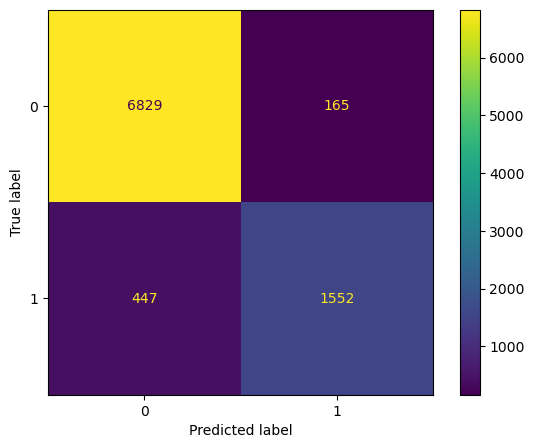

In [45]:
def plot_confusion_matrix(y_true, y_pred, ax=None):
    """Визуализация ConfusionMatrix"""
    labels = list(set(y_pred))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    if ax:
        disp.plot(ax=ax)
    else:
        disp.plot()

# Создаем фигуру и оси
fig, ax = plt.subplots(figsize=(7, 5))

# Визуализируем матрицу ошибок
plot_confusion_matrix(y_true=y_test, y_pred=y_pred_final, ax=ax)
plt.show()

In [47]:
meta_X['index'] = meta_X.index

In [48]:
meta_X_test['index'] = meta_X_test.index

In [52]:
meta_X.to_csv('meta_X_baseline.csv', index=False)

In [54]:
meta_X_test.to_csv('meta_X_test_baseline.csv', index=False)

In [51]:
df_metrics.to_csv('models_metrics.csv', index=False)